# Preprocessing

## Loading data / packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import bigfish.detection as detection

# RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-09 - SeqFISH_Run10 - HeLa-Puro_POLR2" 
RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather")
Spots = pd.read_feather(RUN_PATH + "/result_tables/Spots.feather")
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")
Gene_map = pd.read_feather(RUN_PATH + "/result_tables/Gene_map.feather")

## Spots filtering

### Washout

In [3]:
check_len = len(Spots)
Spots = Spots.loc[~Spots['is_washout']]
print(f"{check_len - len(Spots)} spots filtered.")

1344 spots filtered.


### Out of segmentation

In [4]:
check_len = len(Spots)
Spots = Spots.loc[Spots['cell_label'] != 0]
print(f"{check_len - len(Spots)} spots filtered.")

37093 spots filtered.


## Data merge

In [6]:
check_len = len(Detection)
Detection = pd.merge(
    Detection,
    Acquisition.loc[:,['acquisition_id', 'cycle', 'location']],
    on= 'acquisition_id',
    suffixes=('','_acquisition')
)
assert len(Detection) == check_len

Detection = pd.merge(
    Detection,
    Gene_map.loc[:,['cycle','color_id','target']],
    on= ['cycle','color_id']
)
assert len(Detection) == check_len

check_len = len(Spots)
Spots = pd.merge(
    Spots,
    Detection.loc[:,['detection_id', 'acquisition_id', 'target', 'location']],
    on= 'detection_id'
)
assert len(Spots) == check_len


# General clustering

Here we perform DBSCAN algorithm by pulling together spots from all channels so as to identify site of interaction between channels

- can we produce a 3D heatmap showing density of spots per pixel ?
- add new multichannel clusters to viewer
- additional graph analysis

*Note : functional version of this code available in **density.py***

## Post-processing

### Parameters

In [8]:
VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]

MIN_NB_CLUSTER = 3 # Number for multiRNA cluster analysis

CLUSTER_RADIUS = 400 # Colocalization analysis
# CLUSTER_RADIUS = Detection['cluster_size'].iat[0] # regular clustering

### Pooling data

In [9]:
spots_coordinates_per_fov = Spots.groupby(['location']).agg({
    'z' : list,
    'y' : list,
    'x' : list,
    })
spots_coordinates_per_fov

z  \
location                                                         
Location-01  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-02  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-03  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-04  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-05  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-06  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-07  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-08  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-09  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-10  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   

                                                             y  \
location                                                         
Location-01  [0, 77, 141, 144, 265, 282, 284, 291, 305, 349...   
Location-02  [4, 26, 35, 46, 53, 54, 56, 74, 105, 118, 121,...   
Location-03  [8, 20, 32, 45, 64, 79, 84, 84, 86, 89, 96, 11...   
Location-04  [14, 21, 28, 29, 33, 33, 40, 54, 55, 57, 58, 5...   
Location-05  [0, 10, 16, 76, 77, 96, 97, 111, 112, 128, 134...   
Location-06  [10, 28, 33, 127, 170, 174, 244, 248, 253, 255...   
Location-07  [201, 202, 241, 250, 250, 268, 275, 313, 316, ...   
Location-08  [3, 128, 137, 143, 158, 160, 178, 211, 215, 22...   
Location-09  [50, 56, 60, 60, 104, 117, 119, 119, 122, 127,...   
Location-10  [48, 115, 153, 320, 329, 478, 484, 487, 491, 4...   

                                                             x  
location                                                        
Location-01  [597, 389, 993, 1107, 673, 617, 575, 208, 648,...  
Location-02  [1266, 531, 1282, 1236, 1234, 693, 556, 1260, ...  
Location-03  [699, 1219, 640, 642, 728, 942, 962, 1309, 721...  
Location-04  [266, 1104, 350, 332, 305, 1082, 279, 1044, 58...  
Location-05  [1043, 1018, 1047, 1004, 1146, 1094, 1106, 163...  
Location-06  [92, 100, 77, 837, 1146, 1200, 254, 62, 814, 1...  
Location-07  [1101, 1579, 373, 400, 1099, 1128, 1180, 728, ...  
Location-08  [25, 716, 668, 693, 598, 520, 668, 609, 625, 5...  
Location-09  [1755, 1711, 1757, 1762, 1900, 1861, 1840, 187...  
Location-10  [939, 1379, 210, 981, 984, 965, 666, 960, 904,...

### DBSCAN

In [11]:
Spots_clustered = pd.DataFrame(columns=['cluster_id','z','y','x', 'location'])
for location in spots_coordinates_per_fov.index : 
    data_selec = spots_coordinates_per_fov.loc[location]

    spots = np.array(
        list(zip(data_selec['z'],data_selec['y'],data_selec['x'],)),
        dtype=int)

    clustered_spot, clusters = detection.detect_clusters(
        spots,
        VOXEL_SIZE,
        CLUSTER_RADIUS,
        MIN_NB_CLUSTER,
    )

    z,y,x, cluster_id = zip(*clustered_spot)
    cluster_z, cluster_y, cluster_x, spot_number, cluster_index = zip(*clusters)

    new_Spots_clustered = pd.DataFrame({
            'cluster_id' : cluster_id,
            'z' : z,
            'y' : y,
            'x' : x,
            'location' : location,
        })
    
    new_Clusters = pd.DataFrame({
        'cluster_id' : cluster_index,
        'cluster_centroid_z' : cluster_z, 
        'cluster_centroid_y' : cluster_y, 
        'cluster_centroid_x' : cluster_x, 
    })

    check_len = len(new_Spots_clustered)
    new_Spots_clustered = pd.merge(
        new_Spots_clustered,
        new_Clusters,
        on='cluster_id',
        how='left',
        validate='m:1'
    )
    assert len(new_Spots_clustered) == check_len , "check for duplication"

    Spots_clustered = pd.concat([
        Spots_clustered,
        new_Spots_clustered,
    ], axis= 0)

Spots_clustered

cluster_id   z     y     x     location  cluster_centroid_z  \
0             -1   5     0   597  Location-01                 NaN   
1             -1   5    77   389  Location-01                 NaN   
2             -1   5   141   993  Location-01                 NaN   
3             -1   5   144  1107  Location-01                 NaN   
4            832   5   265   673  Location-01                 5.0   
...          ...  ..   ...   ...          ...                 ...   
31801         -1  47   867  1705  Location-10                 NaN   
31802         -1  47  1463   583  Location-10                 NaN   
31803         -1  47  1656   934  Location-10                 NaN   
31804         -1  48  1786  1581  Location-10                 NaN   
31805        981  48  1299   621  Location-10                47.0   

       cluster_centroid_y  cluster_centroid_x  
0                     NaN                 NaN  
1                     NaN                 NaN  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                   262.0               673.0  
...                   ...                 ...  
31801                 NaN                 NaN  
31802                 NaN                 NaN  
31803                 NaN                 NaN  
31804                 NaN                 NaN  
31805              1299.0               621.0  

[300295 rows x 8 columns]

### Duplicated values after clustering

This dataframe is expected to contain duplicated values for spots with perfect colocalization. What is important for downstream analysis is that they have the same cluster_id. Next step is to retrieve this cluster id to the main Spots table, to avoid duplication during merge on coordinates, we remove duplicated rows.

In [12]:
Spots_clustered[Spots_clustered.duplicated()]

cluster_id   z     y     x     location  cluster_centroid_z  \
1505          -1   6   380  1212  Location-01                 NaN   
1522          52   6   867   383  Location-01                 7.0   
1537          -1   5  1040   538  Location-01                 NaN   
1553          57   5  1115   779  Location-01                 5.0   
1557          -1   7  1114   747  Location-01                 NaN   
...          ...  ..   ...   ...          ...                 ...   
31294         -1  17  1621   557  Location-10                 NaN   
31355         -1  20   600    63  Location-10                 NaN   
31462        972  25   844   501  Location-10                24.0   
31741         -1  43   482   251  Location-10                 NaN   
31767         -1  43   426  1227  Location-10                 NaN   

       cluster_centroid_y  cluster_centroid_x  
1505                  NaN                 NaN  
1522                867.0               383.0  
1537                  NaN                 NaN  
1553               1115.0               780.0  
1557                  NaN                 NaN  
...                   ...                 ...  
31294                 NaN                 NaN  
31355                 NaN                 NaN  
31462               843.0               501.0  
31741                 NaN                 NaN  
31767                 NaN                 NaN  

[4564 rows x 8 columns]

In [13]:
prev_len = len(Spots_clustered)
Spots_clustered = Spots_clustered.drop_duplicates()
print("{0} duplicates dropped.".format(prev_len - len(Spots_clustered)))

4564 duplicates dropped.


### Merging data into main Spots frame

In [15]:
check_len = len(Spots) #No filter/duplication expected.

Spots_clustered = Spots_clustered.rename(columns={'cluster_id' : 'general_cluster_id'})
print("clustered :",len(Spots_clustered))

Spots = pd.merge(
    Spots,
    Spots_clustered,
    on=['location','z','y','x'],
    validate= 'm:1'
)

assert len(Spots) == check_len
Spots

clustered : 295731


spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0             0         NaN          5          0        597       5927   
1             1         NaN          5         77        389       6095   
2             2         NaN          5        141        993       6923   
3             3         NaN          5        144       1107       6960   
4             4         NaN          5        265        673       7111   
...         ...         ...        ...        ...        ...        ...   
300290   338724         NaN         47        867       1705       4061   
300291   338726         NaN         47       1463        583       4628   
300292   338728         NaN         47       1656        934       4044   
300293   338729         NaN         48       1786       1581       4024   
300294   338731         6.0         48       1299        621       4413   

       population  detection_id  acquisition_id_x  drift_z  ...  \
0            free             1                 0        0  ...   
1            free             1                 0        0  ...   
2            free             1                 0        0  ...   
3            free             1                 0        0  ...   
4            free             1                 0        0  ...   
...           ...           ...               ...      ...  ...   
300290       free           208               189        0  ...   
300291       free           208               189        0  ...   
300292       free           208               189        0  ...   
300293       free           208               189        0  ...   
300294  clustered           208               189        0  ...   

             coordinates  in_nucleus  cell_label  acquisition_id_y  target  \
0            [5, 0, 597]        True         2.0                 0  POLR2A   
1           [5, 77, 389]       False         1.0                 0  POLR2A   
2          [5, 141, 993]       False         5.0                 0  POLR2A   
3         [5, 144, 1107]        True         5.0                 0  POLR2A   
4          [5, 265, 673]        True         6.0                 0  POLR2A   
...                  ...         ...         ...               ...     ...   
300290   [47, 867, 1705]       False        19.0               189  POLR2L   
300291   [47, 1463, 583]        True        27.0               189  POLR2L   
300292   [47, 1656, 934]       False        37.0               189  POLR2L   
300293  [48, 1786, 1581]       False        39.0               189  POLR2L   
300294   [48, 1299, 621]        True        38.0               189  POLR2L   

           location general_cluster_id cluster_centroid_z  cluster_centroid_y  \
0       Location-01                 -1                NaN                 NaN   
1       Location-01                 -1                NaN                 NaN   
2       Location-01                 -1                NaN                 NaN   
3       Location-01                 -1                NaN                 NaN   
4       Location-01                832                5.0               262.0   
...             ...                ...                ...                 ...   
300290  Location-10                 -1                NaN                 NaN   
300291  Location-10                 -1                NaN                 NaN   
300292  Location-10                 -1                NaN                 NaN   
300293  Location-10                 -1                NaN                 NaN   
300294  Location-10                981               47.0              1299.0   

       cluster_centroid_x  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                   673.0  
...                   ...  
300290                NaN  
300291                NaN  
300292                NaN  
300293                NaN  
300294              621.0  

[300295 rows x 31 columns]

# Analysis

### Data grouping

In [16]:
Clustered_spots = Spots.loc[Spots['general_cluster_id'] != -1]

multichannel_clusters = Clustered_spots.groupby(['location', 'general_cluster_id']).aggregate({
    'spot_id' : 'count',
    'target' : ['nunique','unique'],
    'cluster_centroid_z' : 'first',
    'cluster_centroid_y' : 'first',
    'cluster_centroid_x' : 'first',
})

multichannel_clusters.columns = pd.Index(['spot number', 'rna number', 'rna list', 'z', 'y', 'x'])

multichannel_clusters.to_excel(OUTPUT_PATH + "Multichannel_cluster.xlsx")
multichannel_clusters

spot number  rna number  \
location    general_cluster_id                            
Location-01 0                             6           4   
            1                             3           3   
            2                             6           5   
            3                             3           3   
            4                             4           3   
...                                     ...         ...   
Location-10 984                           5           1   
            985                           3           1   
            986                           3           2   
            987                           3           1   
            988                           3           2   

                                                                rna list  \
location    general_cluster_id                                             
Location-01 0                           [POLR2A, POLR2E, POLR2F, POLR2H]   
            1                                   [POLR2A, POLR2H, POLR2J]   
            2                   [POLR2A, POLR2B, POLR2J, POLR2K, POLR2L]   
            3                                   [POLR2A, POLR2B, POLR2F]   
            4                                   [POLR2A, POLR2H, POLR2K]   
...                                                                  ...   
Location-10 984                                                 [POLR2L]   
            985                                                 [POLR2L]   
            986                                         [POLR2C, POLR2L]   
            987                                                 [POLR2L]   
            988                                         [POLR2A, POLR2L]   

                                   z       y       x  
location    general_cluster_id                        
Location-01 0                    5.0   351.0   964.0  
            1                    5.0   486.0   222.0  
            2                    5.0   893.0   413.0  
            3                    5.0   912.0   765.0  
            4                    5.0  1089.0   842.0  
...                              ...     ...     ...  
Location-10 984                 17.0    97.0  1859.0  
            985                 26.0  1497.0    30.0  
            986                 41.0   772.0  1226.0  
            987                 39.0   789.0   705.0  
            988                 40.0   490.0   425.0  

[10452 rows x 6 columns]

In [36]:
updated_spots = pd.merge(
    Spots,
    multichannel_clusters.loc[:,['rna number']],
    on=['location','general_cluster_id'],
)
assert len(Spots[Spots['general_cluster_id'] != -1]) == len(updated_spots), "Non unique (location,general_cluster_id)"
updated_spots

spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0            4         NaN          5        265        673       7111   
1        21816         NaN          5        259        673       6813   
2        23507         NaN          5        262        673       8489   
3            8         NaN          5        305        648       7325   
4        16128         NaN          5        301        643       8909   
...        ...         ...        ...        ...        ...        ...   
41414   338303        10.0         26       1496         30       6371   
41415   338304        10.0         26       1498         30       6232   
41416   338601         NaN         39        790        705       4748   
41417   338602         NaN         39        789        706       4552   
41418   338662         NaN         41        790        705       4450   

      population  detection_id  acquisition_id_x  drift_z  ...  in_nucleus  \
0           free             1                 0        0  ...        True   
1           free            13               120        0  ...        True   
2           free            15               140        0  ...        True   
3           free             1                 0        0  ...        True   
4           free             9                80        0  ...        True   
...          ...           ...               ...      ...  ...         ...   
41414  clustered           208               189        0  ...        True   
41415  clustered           208               189        0  ...        True   
41416       free           208               189        0  ...       False   
41417       free           208               189        0  ...       False   
41418       free           208               189        0  ...       False   

       cell_label  acquisition_id_y  target     location general_cluster_id  \
0             6.0                 0  POLR2A  Location-01                832   
1             6.0               120  POLR2I  Location-01                832   
2             6.0               140  POLR2J  Location-01                832   
3             6.0                 0  POLR2A  Location-01                775   
4             6.0                80  POLR2F  Location-01                775   
...           ...               ...     ...          ...                ...   
41414        43.0               189  POLR2L  Location-10                985   
41415        43.0               189  POLR2L  Location-10                985   
41416        14.0               189  POLR2L  Location-10                987   
41417        14.0               189  POLR2L  Location-10                987   
41418        14.0               189  POLR2L  Location-10                987   

      cluster_centroid_z cluster_centroid_y  cluster_centroid_x rna number  
0                    5.0              262.0               673.0          3  
1                    5.0              262.0               673.0          3  
2                    5.0              262.0               673.0          3  
3                    5.0              304.0               645.0          4  
4                    5.0              304.0               645.0          4  
...                  ...                ...                 ...        ...  
41414               26.0             1497.0                30.0          1  
41415               26.0             1497.0                30.0          1  
41416               39.0              789.0               705.0          1  
41417               39.0              789.0               705.0          1  
41418               39.0              789.0               705.0          1  

[41419 rows x 32 columns]

## General Plots

### Number of cluster with n number of RNA

In [37]:
cluster_plurality_number = multichannel_clusters['rna number'].unique()
cluster_plurality_number = list(cluster_plurality_number)
cluster_plurality_number.sort()
print(f"{len(cluster_plurality_number)} different size of cluster found.")
cluster_plurality_number

10 different size of cluster found.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Total rna number VS diversity of cluster

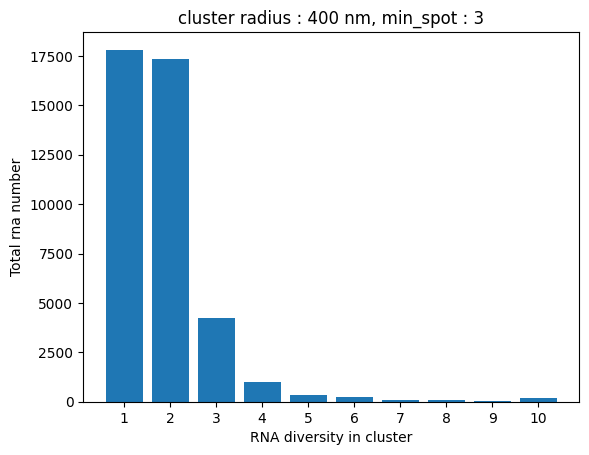

In [38]:
fig = plt.figure()
ax = fig.gca()

data = multichannel_clusters.groupby("rna number")['spot number'].sum()
ax.bar(data.index, data, align='center')
ax.set_xticks(data.index)
ax.set_ylabel("Total rna number")
ax.set_xlabel("RNA diversity in cluster")
ax.set_title(f"cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

plt.show()

### Total rna number per RNA per diversity

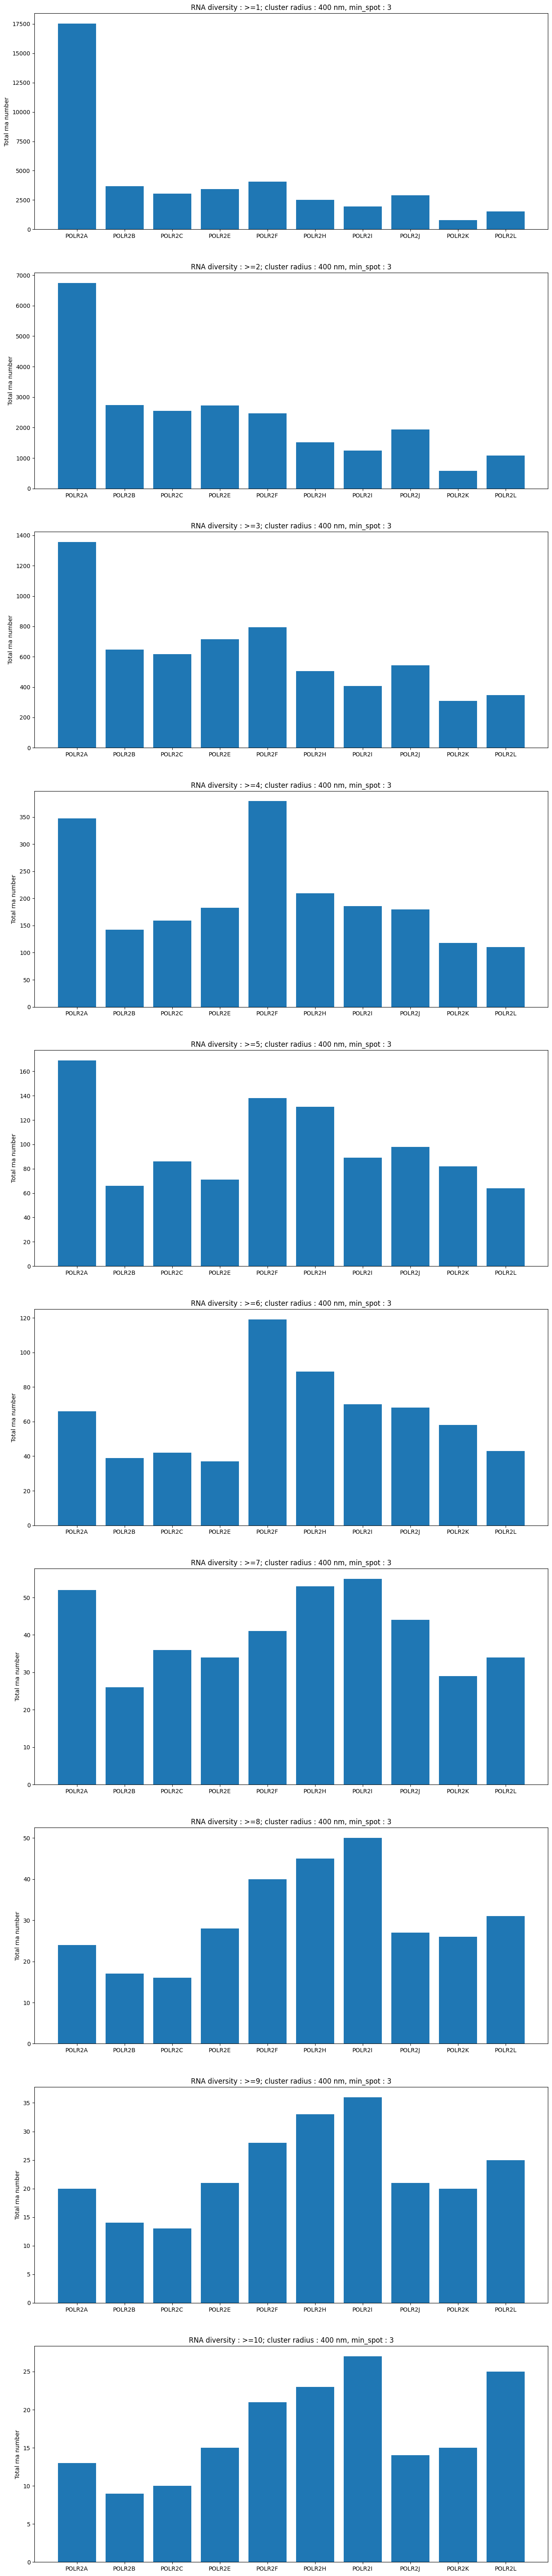

In [39]:
fig, axes = plt.subplots(nrows= len(cluster_plurality_number), ncols=1, figsize = (16,8*len(cluster_plurality_number)))

for ax, dimension in zip(axes, cluster_plurality_number) :
    ax:plt.Axes
    ax.set_title(f"RNA diversity : >={dimension}; cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

    data = updated_spots.loc[updated_spots['rna number'] >= dimension]
    data = data.groupby('target')['spot_id'].count()


    X = list(range(len(data)))
    ax.bar(X, data,align='center')
    ax.set_xticks(X, labels=data.index)
    ax.set_ylabel("Total rna number")

plt.show()

## Affinity & presence


### Cluster unity table

Here we build a DataFrame showing for each cluster the number of single molecules from each RNA in the dataset

In [40]:
MIN_DIVERSITY = 3

In [41]:
#Filtering spots from cluster with less than MIN_DIVERSITY different rnas.
data = updated_spots.loc[updated_spots['rna number'] >= MIN_DIVERSITY]

#Init empty table : each line is a cluster and each RNA of data set are reprensented in columns with their single molecule number in this cluster; init to 0.
cluster_list = pd.Series(zip(data['location'], data['general_cluster_id'])).unique()
cluster_list = pd.MultiIndex.from_tuples(cluster_list)
RNA_list = data['target'].unique()
cluster_unity_counts = pd.DataFrame(index=cluster_list, columns=RNA_list, dtype=int, data=0).sort_index()

#Creating table with all counts of single molecule per cluster per rna
agg_table = data.groupby(['location', 'general_cluster_id','target'])['spot_id'].count()
for location, cluster_id, rna in agg_table.index :
    value = agg_table.at[(location,cluster_id,rna)]
    cluster_unity_counts.loc[(location,cluster_id), rna] += value

#Assign values from groupby to cluster table
total = cluster_unity_counts.sum(axis=1).astype(int)
cluster_unity_counts

POLR2A  POLR2I  POLR2J  POLR2F  POLR2H  POLR2E  POLR2B  \
Location-01 0         1       0       0       2       1       2       0   
            1         1       0       1       0       1       0       0   
            2         1       0       1       0       0       0       2   
            3         1       0       0       1       0       0       1   
            4         1       0       0       0       1       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 849       0       0       3       0       3       0       0   
            889       0       1       0       1       0       0       0   
            891       0       2       0       1       1       0       0   
            901       1       1       1       0       0       0       0   
            962       0       0       0       1       1       0       0   

                 POLR2K  POLR2L  POLR2C  
Location-01 0         0       0       0  
            1         0       0       0  
            2         1       1       0  
            3         0       0       0  
            4         2       0       0  
...                 ...     ...     ...  
Location-10 849       0       1       0  
            889       2       0       0  
            891       0       0       0  
            901       0       0       0  
            962       1       0       0  

[1159 rows x 10 columns]

### Affinity & Presence tables

In [42]:
presence_dict = {}
affinity_dict = {}

for rna in RNA_list :
    rna_index = cluster_unity_counts.loc[cluster_unity_counts[rna] > 0].index
    data = cluster_unity_counts.loc[rna_index]

    affinity_df = data.apply(lambda x : x/total.loc[rna_index])
    affinity_df_total = affinity_df.sum(axis=1).round(10)
    assert (affinity_df_total == 1).all(), affinity_df[affinity_df_total != 1]
    affinity_dict[rna] = affinity_df

    presence_df = data.apply(lambda x : x.astype(bool))
    presence_dict[rna] = presence_df



presence_df


POLR2A  POLR2I  POLR2J  POLR2F  POLR2H  POLR2E  POLR2B  \
Location-01 11     True   False   False   False   False    True   False   
            23     True   False   False   False   False    True   False   
            57     True    True   False   False   False   False    True   
            62     True   False   False   False   False    True   False   
            69     True   False   False   False   False   False   False   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 672   False    True   False   False   False    True   False   
            690   False   False   False    True   False   False   False   
            691   False   False   False    True    True   False   False   
            762   False   False    True   False   False    True   False   
            809   False   False   False    True   False   False   False   

                 POLR2K  POLR2L  POLR2C  
Location-01 11    False   False    True  
            23    False   False    True  
            57     True   False    True  
            62    False   False    True  
            69     True   False    True  
...                 ...     ...     ...  
Location-10 672   False   False    True  
            690   False    True    True  
            691   False   False    True  
            762   False   False    True  
            809   False    True    True  

[410 rows x 10 columns]

### Presence plots

Shows for each rna when it was found in a cluster of often other RNA were found in that cluster

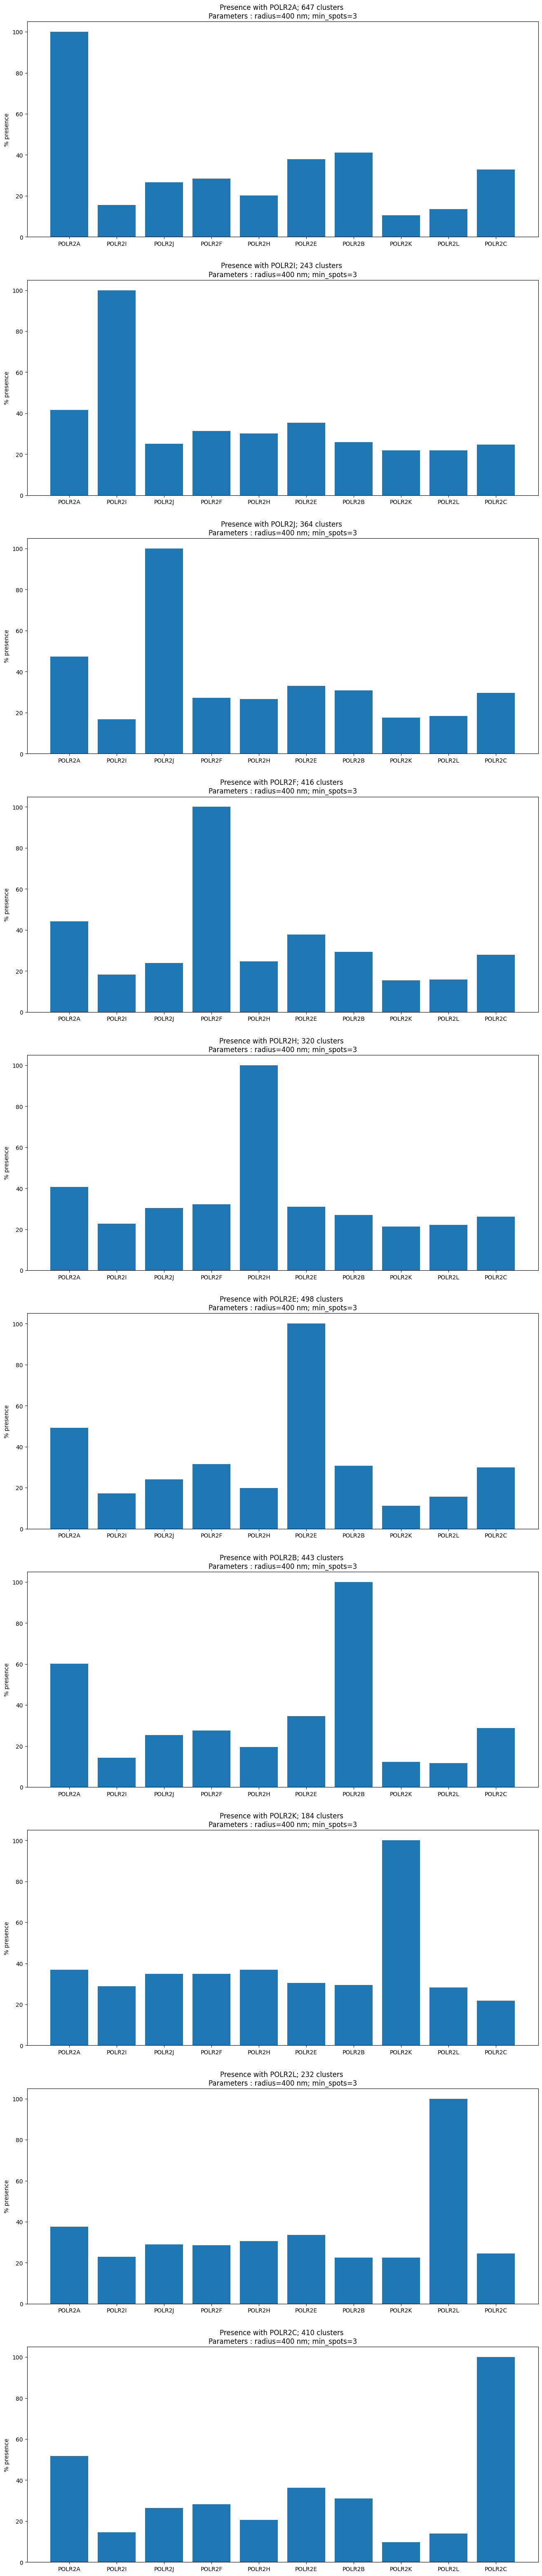

In [43]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = presence_dict[rna]
    cluster_number = len(data)
    data = data.sum(axis=0) / cluster_number * 100

    ax.set_title(f"Presence with {rna}; {cluster_number} clusters \nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("% presence")

plt.show()

### Affinity plots

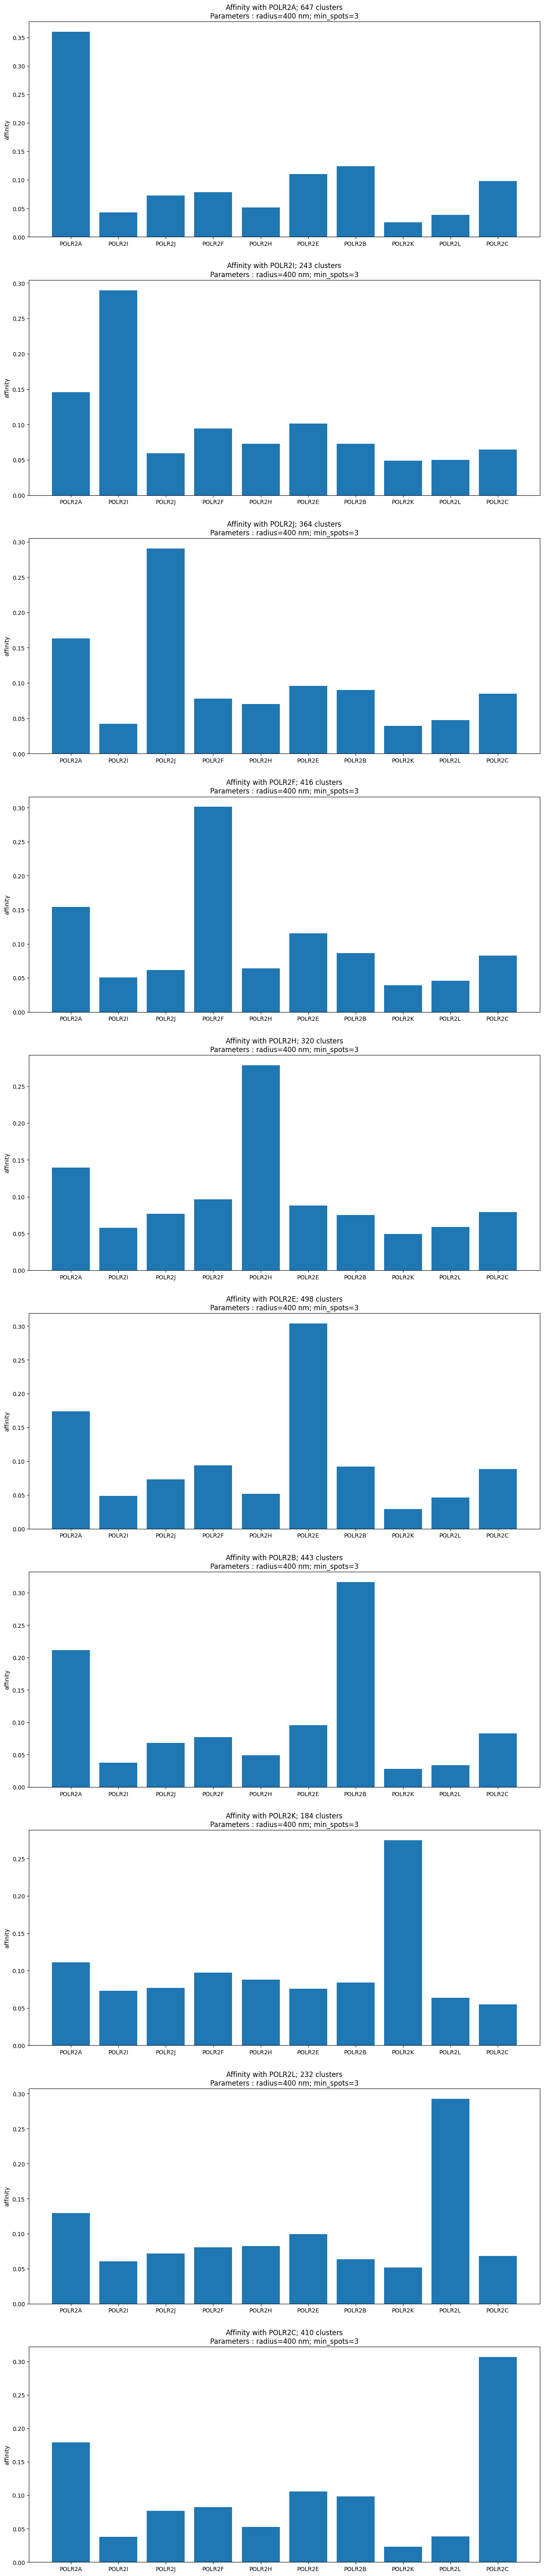

In [44]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = affinity_dict[rna]
    cluster_number = len(data)
    data = data.mean(axis=0)
    data_std = data.std(axis=0)

    ax.set_title(f"Affinity with {rna}; {cluster_number} clusters\nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("affinity")

plt.show()